# Load libraries

In [1]:
%matplotlib inline

import os
import math

import configparser

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sys
sys.path.append('../..')

from scripps.utils import read_datasets, norm1d, bayesian_linear_regression
from IPython.core.display import clear_output
import seaborn as sns

from collections import defaultdict

In [2]:
np.random.seed(42) 

# Load all mark2cure citizen scientist annotations

In [3]:
CF = read_datasets.get_configuration()

def read_disease_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_citizen_disease', 'files1')
    anno[3].replace(['I-Disease', 'O'], [1, 0], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[3].rename('Annotator1')], axis=1)
    for i in range(2, 6):
        anno = read_datasets.load_dataset('m2c_citizen_disease', 'files{}'.format(i))
        anno[3].replace(['I-Disease', 'O'], [1, 0], inplace=True)
        annotations = pd.concat([annotations, anno[3].rename('Annotator{}'.format(i))], axis=1)
    return annotations

def read_phenotype_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_citizen_phenotype', 'files1')
    anno[3].replace(['I-Phenotype', 'O'], [1, 0], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[3].rename('Annotator1')], axis=1)
    for i in range(2, 6):
        anno = read_datasets.load_dataset('m2c_citizen_phenotype', 'files{}'.format(i))
        anno[3].replace(['I-Phenotype', 'O'], [1, 0], inplace=True)
        annotations = pd.concat([annotations, anno[3].rename('Annotator{}'.format(i))], axis=1)
    return annotations

In [4]:
disease_annotations = read_disease_annotations()
phenotype_annotations = read_phenotype_annotations()

In [7]:
num_annotators = 5
num_tokens = disease_annotations.shape[0]

disease_relevant = pd.DataFrame()
phenotype_relevant = pd.DataFrame()

relevant = []

for k in range(num_tokens):
    disease = 0
    phenotype = 0 
    
    
    nones = []
    for j in range(1, num_annotators+1):                
        d = disease_annotations['Annotator{}'.format(j)][k]
        p = phenotype_annotations['Annotator{}'.format(j)][k]
                
        if d == 0 and p == 0:
            nones.append(j-1)
            
        disease += d 
        phenotype += p
                
                
    if disease == 0 and phenotype == 0:        
        continue
    else:
        relevant.append(k)
#         for j in nones:            
#             has_nones[j].append(len(relevant))        
        

relevant = np.array(relevant)
print '{} relevant words.'.format(relevant.size)

disease_relevant = disease_annotations.iloc[relevant]
phenotype_relevant = phenotype_annotations.iloc[relevant]

has_nones = defaultdict(set)
has_no_nones = defaultdict(set)
for j in range(num_annotators):
    for i, k in enumerate(relevant):
        if disease_relevant['Annotator{}'.format(j+1)][k] == 0 and \
        phenotype_relevant['Annotator{}'.format(j+1)][k] == 0:
            has_nones[j].add(i)
        else:
            has_no_nones[j].add(i)

for j in range(num_annotators):
    has_no_nones[j] = np.array(list(has_no_nones[j]))
    has_nones[j] = np.array(list(has_nones[j]))

1611 relevant words.


# Initialize latent variables

In [8]:
K = disease_relevant.shape[0]
J = disease_relevant.shape[1] - 1

latent = {}

latent['theta'] = np.zeros(K)
latent['d_alpha'] = np.zeros(J)
latent['d_beta'] = np.zeros(J)
latent['d_z'] = np.zeros((K, J))

latent['theta'] = np.zeros(K)
latent['p_alpha'] = np.zeros(J)
latent['p_beta'] = np.zeros(J)
latent['p_z'] = np.zeros((K, J))

# for j in has_nones:
#     latent['p_z'][has_nones[j], j] = latent['d_z'][has_nones[j] ,j] = np.nan

#Should these be separate for disease and phenotype?
latent['b0'] = np.zeros(2)
latent['B0_scale'] = 1
latent['m0'] = np.zeros(K) #TODO: ask HS regarding changing certain values here.
latent['C0_scale'] = 1

latent['K'] = K
latent['J'] = J

# Define functions for resampling using Gibbs sampling

In [9]:
def __get_alpha_beta_z(mode):
    if mode == 'disease':
        alpha = latent['d_alpha']
        beta = latent['d_beta']
        z = latent['d_z']
    else:
        alpha = latent['p_alpha']
        beta = latent['p_beta']
        z = latent['p_z']
    return alpha, beta, z
    

In [10]:
def __resample_z(alpha, beta, z, annotations):
    interval = [-100, 100] #Should this be changed?
    for k in range(K):
        for j in range(J):
            if k in has_nones[j]: continue
            mean = alpha[j] + beta[j]*latent['theta'][k]
            std_dev = 1
            if(annotations['Annotator{}'.format(j+1)][relevant[k]] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations['Annotator{}'.format(j+1)][relevant[k]] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
    
def resample_z(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    if mode == 'disease':
        annotations = disease_relevant
    else:
        annotations = phenotype_relevant
    __resample_z(alpha, beta, z, annotations)
    return latent['d_z'] if mode == 'disease' else latent['p_z']

In [11]:
def __resample_alpha_beta(alpha, beta, z):
    for j in range(J):
        Y = z[has_no_nones[j], j]
        X = np.vstack((np.ones(len(has_no_nones[j])), latent['theta'][has_no_nones[j]])).T
        
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['b0'], latent['B0_scale'], 1)
        sample = np.random.multivariate_normal(WN, VN)
        alpha[j] = sample[0]
        beta[j] = sample[1]

def resample_alpha_beta(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    __resample_alpha_beta(alpha, beta, z)
    return alpha, beta

In [12]:
def resample_theta():
    for k in range(K):     
        a = []
        for j in range(num_annotators):
            if k in has_no_nones[j]:
                a.append(j)
        a = np.array(a)
        Y = np.concatenate((latent['d_z'][k, a] - latent['d_alpha'][a], latent['p_z'][k, a] - latent['p_alpha'][a]))
        X = np.concatenate((latent['d_beta'][a], latent['p_beta'][a]))
        X = np.reshape(X, (-1, 1))
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['m0'][k], latent['C0_scale'], 1)
        latent['theta'][k] = np.random.normal(WN, math.sqrt(VN))    

In [13]:
def save_latent_variables():
    #TODO: save to csv.
    pass


def resample():
    d_z = resample_z('disease')
    p_z = resample_z('phenotype')
    
    resample_theta()
        
    d_alpha, d_beta = resample_alpha_beta('disease')
    p_alpha, p_beta = resample_alpha_beta('phenotype')    
    
    save_latent_variables()
    
    return latent['theta'], d_alpha, d_beta, p_alpha, p_beta, d_z, p_z
    
def has_converged():
    #TODO
    pass

def summarize_param(params, burn_in):
    return np.mean(params[burn_in:], axis=0)


def run_sampling(num_iter, burn_in): 
    zs = []
    thetas = []
    d_alphas = []
    d_betas = []
    p_alphas = []
    p_betas = []
    d_zs = []
    p_zs = []
    
    #TODO: consider first step, when we decide if word is relevant or not.
    for it in xrange(1, num_iter+1):
        theta, d_alpha, d_beta, p_alpha, p_beta, d_z, p_z = resample()
        thetas.append(np.array(theta))
        d_alphas.append(np.array(d_alpha))
        d_betas.append(np.array(d_beta))
        p_alphas.append(np.array(p_alpha))
        p_betas.append(np.array(p_beta))
        d_zs.append(np.array(d_z))
        p_zs.append(np.array(p_z))
        
        if it%5 == 0:
            clear_output()
            print 'Iter {}/{} done.'.format(it, num_iter)
        if has_converged():
            break
    
    all_vars = {}            
    all_vars['thetas'] = thetas
    all_vars['d_alphas'] = d_alphas
    all_vars['d_betas'] = d_betas
    all_vars['p_alphas'] = p_alphas
    all_vars['p_betas'] = p_betas
    all_vars['d_zs'] = d_zs
    all_vars['p_zs'] = p_zs
    
    summary = {}                  
    summary['avg_d_alpha'] = summarize_param(d_alphas, burn_in)
    summary['avg_d_beta'] = summarize_param(d_betas, burn_in)
    summary['avg_p_alpha'] = summarize_param(p_alphas, burn_in)
    summary['avg_p_beta'] = summarize_param(p_betas, burn_in)
    summary['avg_theta'] = summarize_param(thetas, burn_in)    
    summary['avg_d_z'] = summarize_param(d_zs, burn_in)    
    summary['avg_p_z'] = summarize_param(p_zs, burn_in)    
      
    return all_vars, summary

In [14]:
all_vars, summary = run_sampling(2500, 200)

Iter 2500/2500 done.


In [15]:
print 'avg_d_alpha:', summary['avg_d_alpha']
print 'avg_d_beta:', summary['avg_d_beta']
print 'avg_p_alpha:', summary['avg_p_alpha']
print 'avg_p_beta:', summary['avg_p_beta']
print 'avg_theta:', summary['avg_theta']

avg_d_alpha: [ 0.69907888 -0.0990451   0.22723617 -0.58292019  0.63563353]
avg_d_beta: [-2.25698935 -4.31370661 -2.03111907 -2.85114158 -2.79794846]
avg_p_alpha: [ 0.27598734  0.53953449  0.79753148  1.35261136 -0.44265061]
avg_p_beta: [2.30799401 3.3083825  2.14121915 1.77044708 3.37490246]
avg_theta: [ 0.36190215 -0.83872324 -0.83274768 ... -0.74418132 -0.78059285
 -1.33472829]


In [26]:
def get_annotator_bias(alpha, beta):
    # compute xr and xa using above latent vars.
#     xa = (4*alpha - beta*beta)/(4*beta)
#     xr = (4*alpha + beta*beta)/(4*beta)
    xa = (-2*alpha/beta - beta/2)/2
    xr = -2*alpha/beta - xa
    return xa, xr

def get_word_positions(theta, relevant):
    positions = pd.DataFrame()
    positions['Tokens'] = disease_annotations['Token']    
    for i in range(1, J+1):
        codes = disease_annotations['Annotator{}'.format(i)].map(str) + \
        phenotype_annotations['Annotator{}'.format(i)].map(str)        
        positions['Annotator{}'.format(i)] = codes
        positions['Annotator{}'.format(i)].\
        replace(['00', '01', '10', '11'], ['None', 'Phenotype', 'Disease', 'Both'], inplace=True)
    
    disease_counts = np.zeros(len(disease_annotations['Token']), dtype=np.int32)
    phenotype_counts = np.zeros(len(phenotype_annotations['Token']), dtype=np.int32)
    for i in range(1, J+1):
        disease_counts += positions['Annotator{}'.format(i)].\
        replace(['Disease', 'Both', 'Phenotype', 'None'], [1, 1, 0, 0])
        phenotype_counts += positions['Annotator{}'.format(i)].\
        replace(['Phenotype', 'Both', 'Disease', 'None'], [1, 1, 0, 0])
    
    positions['Disease'] = disease_counts
    positions['Phenotype'] = phenotype_counts
    
    positions['Position'] = ''
    positions['Position'].iloc[relevant] = theta    
    
    return positions

def plot_bias():
    # show the annotator's location along with the word's true position.
    pass


In [17]:
def alignment_to_expert_positions():
    pass

In [18]:
xpa, xpr = get_annotator_bias(summary['avg_p_alpha'], summary['avg_p_beta'])

In [19]:
xda, xdr = get_annotator_bias(summary['avg_d_alpha'], summary['avg_d_beta'])

In [20]:
xpa - xpr

array([-1.15399701, -1.65419125, -1.07060958, -0.88522354, -1.68745123])

In [21]:
xda - xdr

array([1.12849467, 2.15685331, 1.01555954, 1.42557079, 1.39897423])

In [22]:
(xpa + xpr)/2

array([-0.11957888, -0.16308105, -0.37246607, -0.76399423,  0.13115953])

In [23]:
(xda + xdr)/2

array([ 0.30973956, -0.02296056,  0.11187733, -0.20445151,  0.22717843])

In [24]:
print min(summary['avg_theta'])
print max(summary['avg_theta'])

-1.619501796128934
1.654042782485208


In [27]:
positions = get_word_positions(summary['avg_theta'], relevant)

/home/rohan/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
positions

,Tokens,Annotator1,Annotator2,Annotator3,Annotator4,Annotator5,Disease,Phenotype,Position
0,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,2,5,0.361902
1,and,None,None,None,None,None,0,0,
2,abdominal,Disease,Disease,Disease,Both,Disease,5,1,-0.838723
3,aortic,Disease,Disease,Disease,Both,Disease,5,1,-0.832748
4,aneurysm,Disease,Disease,Disease,Both,Disease,5,1,-0.881324
5,.,None,None,None,None,None,0,0,
6,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,2,5,0.369368
7,and,None,None,None,None,None,0,0,
8,left,Phenotype,Phenotype,None,None,Phenotype,0,3,1.25255
9,loin,Phenotype,Phenotype,None,Phenotype,Phenotype,0,4,1.3039


In [29]:
relevant_positions = pd.DataFrame(positions.iloc[relevant]).reset_index(drop=True)

In [30]:
relevant_positions

,Tokens,Annotator1,Annotator2,Annotator3,Annotator4,Annotator5,Disease,Phenotype,Position
0,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,2,5,0.361902
1,abdominal,Disease,Disease,Disease,Both,Disease,5,1,-0.838723
2,aortic,Disease,Disease,Disease,Both,Disease,5,1,-0.832748
3,aneurysm,Disease,Disease,Disease,Both,Disease,5,1,-0.881324
4,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,2,5,0.369368
5,left,Phenotype,Phenotype,None,None,Phenotype,0,3,1.25255
6,loin,Phenotype,Phenotype,None,Phenotype,Phenotype,0,4,1.3039
7,pain,Phenotype,Phenotype,Both,Phenotype,Phenotype,1,5,0.604232
8,abdominal,Disease,Disease,Disease,Both,Disease,5,1,-0.794345
9,aortic,Disease,Disease,Disease,Both,Disease,5,1,-0.823333


In [31]:
def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x=pos_annos['Position'], y="zeros", hue=annotator, data=pos_annos, hue_order=['Disease', 'Both', 'Phenotype'])

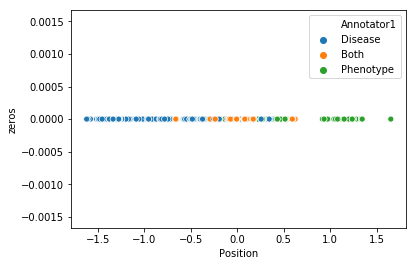

In [32]:
plot_thetas(relevant_positions.loc[has_no_nones[0],:], 'Annotator1')

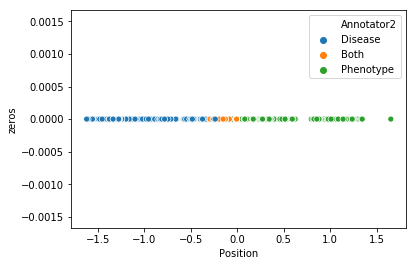

In [33]:
plot_thetas(relevant_positions.loc[has_no_nones[1],:], 'Annotator2')

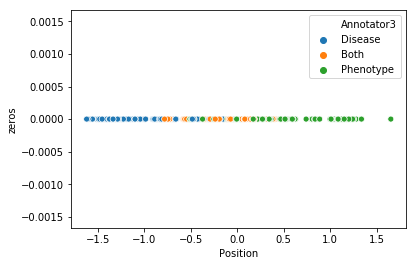

In [34]:
plot_thetas(relevant_positions.loc[has_no_nones[2],:], 'Annotator3')

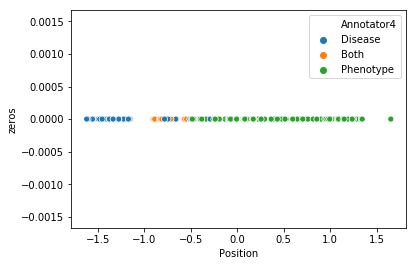

In [35]:
plot_thetas(relevant_positions.loc[has_no_nones[3],:], 'Annotator4')

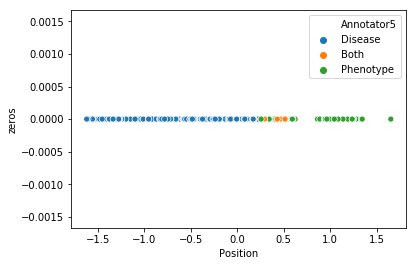

In [36]:
plot_thetas(relevant_positions.loc[has_no_nones[4],:], 'Annotator5')

In [37]:
loc_pd = pd.DataFrame()
#loc_pd['Val'] = ["xda", "xdr", "xpa", "xpr"]
#
#for i in range(5):
#    loc_pd['Annotator{}'.format(i+1)] = [xda[i], xdr[i], xpa[i], xpr[i]]

#loc_pd.index = ["xda", "xdr", "xpa", "xpr"]
loc_pd['xda'] = xda
loc_pd['xdr'] = xdr
loc_pd['xpa'] = xpa
loc_pd['xpr'] = xpr
loc_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]
#ax = sns.scatterplot(x=0, y="zeros", data=dis_loc_pd)

In [38]:
loc_pd

,xda,xdr,xpa,xpr,annotator
0,0.873987,-0.254508,-0.696577,0.457420,Annotator1
1,1.055466,-1.101387,-0.990177,0.664015,Annotator2
2,0.619657,-0.395902,-0.907771,0.162839,Annotator3
3,0.508334,-0.917237,-1.206606,-0.321382,Annotator4
4,0.926666,-0.472309,-0.712566,0.974885,Annotator5


### '''
loc_pd = pd.DataFrame()
#loc_pd['disease'] = (xda + xdr)/2
#loc_pd['phenotype'] = (xpa + xpr)/2
loc_pd['disease'] = xda
loc_pd['phenotype'] = xpa
loc_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]
'''
dis_pd = pd.DataFrame()
dis_pd['xda'] = xda
dis_pd['xdr'] = xdr
dis_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]

phe_pd = pd.DataFrame()
phe_pd['xpa'] = xpa
phe_pd['xpr'] = xpr
phe_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]
#'''

sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

print(dis_pd)
print
print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1, ci=None)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1, ci=None)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


     annotator measurement     value
0   Annotator1         xda  0.873987
1   Annotator2         xda  1.055466
2   Annotator3         xda  0.619657
3   Annotator4         xda  0.508334
4   Annotator5         xda  0.926666
5   Annotator1         xdr -0.254508
6   Annotator2         xdr -1.101387
7   Annotator3         xdr -0.395902
8   Annotator4         xdr -0.917237
9   Annotator5         xdr -0.472309
10  Annotator1          xd  0.309740
11  Annotator2          xd -0.022961
12  Annotator3          xd  0.111877
13  Annotator4          xd -0.204452
14  Annotator5          xd  0.227178

     annotator measurement     value
0   Annotator1         xpa -0.696577
1   Annotator2         xpa -0.990177
2   Annotator3         xpa -0.907771
3   Annotator4         xpa -1.206606
4   Annotator5         xpa -0.712566
5   Annotator1         xpr  0.457420
6   Annotator2         xpr  0.664015
7   Annotator3         xpr  0.162839
8   Annotator4         xpr -0.321382
9   Annotator5         xpr  0.974885


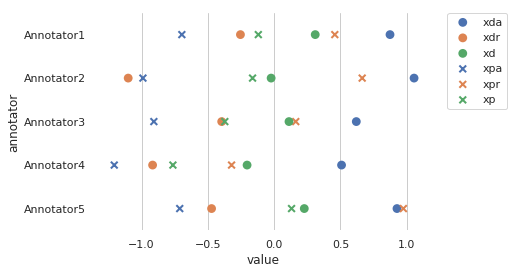

In [39]:
'''
loc_pd = pd.DataFrame()
#loc_pd['disease'] = (xda + xdr)/2
#loc_pd['phenotype'] = (xpa + xpr)/2
loc_pd['disease'] = xda
loc_pd['phenotype'] = xpa
loc_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]
'''
dis_pd = pd.DataFrame()
dis_pd['xda'] = xda
dis_pd['xdr'] = xdr
dis_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]
dis_pd['xd'] = (xda + xdr)/2

phe_pd = pd.DataFrame()
phe_pd['xpa'] = xpa
phe_pd['xpr'] = xpr
phe_pd['xp'] = (xpa + xpr)/2
phe_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]
#'''


sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

print(dis_pd)
print
print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1, ci=None)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1, ci=None)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [40]:
dis_loc = (xda + xdr)/2
phe_loc = (xpa + xpr)/2

phe_loc - dis_loc

array([-0.42931844, -0.14012049, -0.48434339, -0.55954273, -0.0960189 ])

In [41]:
def count_relevant_stats(relevant_annotations, annotator, label):
    return relevant_annotations[relevant_annotations[annotator] == label][annotator].count()

In [42]:
def get_relevant_stats(relevant_annotations, annotator):
    print 'Statistics for {}'.format(annotator)
    print 'Percentage of Disease labels: {:.4f}'.format(count_relevant_stats(relevant_annotations, annotator, 'Disease')/float(len(relevant)))
    print 'Percentage of Phenotype labels: {:.4f}'.format(count_relevant_stats(relevant_annotations, annotator, 'Phenotype')/float(len(relevant)))
    print 'Percentage of Both labels: {:.4f}'.format(count_relevant_stats(relevant_annotations, annotator, 'Both')/float(len(relevant)))
    print 'Percentage of relevant None labels: {:.4f}'.format(count_relevant_stats(relevant_annotations, annotator, 'None')/float(len(relevant)))

In [43]:
get_relevant_stats(relevant_positions, 'Annotator1')

Statistics for Annotator1
Percentage of Disease labels: 0.3215
Percentage of Phenotype labels: 0.0894
Percentage of Both labels: 0.0795
Percentage of relevant None labels: 0.5096


In [44]:
get_relevant_stats(relevant_positions, 'Annotator2')

Statistics for Annotator2
Percentage of Disease labels: 0.3501
Percentage of Phenotype labels: 0.1372
Percentage of Both labels: 0.0379
Percentage of relevant None labels: 0.4749


In [45]:
get_relevant_stats(relevant_positions, 'Annotator3')

Statistics for Annotator3
Percentage of Disease labels: 0.2427
Percentage of Phenotype labels: 0.1198
Percentage of Both labels: 0.0906
Percentage of relevant None labels: 0.5469


In [46]:
get_relevant_stats(relevant_positions, 'Annotator4')

Statistics for Annotator4
Percentage of Disease labels: 0.1850
Percentage of Phenotype labels: 0.2011
Percentage of Both labels: 0.1173
Percentage of relevant None labels: 0.4966


In [47]:
get_relevant_stats(relevant_positions, 'Annotator5')

Statistics for Annotator5
Percentage of Disease labels: 0.4997
Percentage of Phenotype labels: 0.3886
Percentage of Both labels: 0.0286
Percentage of relevant None labels: 0.0832
